# Convergência do processo de minimização

O arquivo padrão de saída **fort.220** contém informações sobre a convergência do processo de minimização em cada loop interno (*inner loop*: iteração de minimização) executado pelo GSI. Com os dados deste arquivo é possível analisar a contribuição de diferentes observações na função custo (`J`) em relação ao custo total (`cost`). Informações sobre a norma/produto interno dos gradientes (`grad`), stepsize e indicação da nova direção de busca (`b`) do método dos gradientes conjugados também são fornecidas. Mais informações sobre os dados fornecidos pelo arquivo **fort.220** estão disponíveis nos guias do GSI: User’s Guide Version v3.7 (seção 4.6) e Advanced User’s Guide v3.5 (seção 3.1).


## Leitura do arquivo **fort.220** 

Para leitura do arquivo **fort.220** foram elaboradas as funções dentro da classe `read_diag`:

1. `fort_220_cost_gradient(DIRdiag, dates)`: esta função lê todas as linhas do arquvio fort.220 e identifica as linhas com as expressões `Minimization iteration`, `costterms Jb,Jo,Jc,Jl  =` e `cost,grad,step,b,step? =`. Utilizando os valores de cada variável (identificada por `Label`) são constuídos dois dataframes (duas tabelas) onde as colunas são, na ordem, as variáveis `'InnerLoop', 'Jb', 'Jo', 'Jc', 'Jl', 'cost', 'grad', 'step', 'b' e 'step?'`. O primeiro dataframe corresponde aos valores de cada variável nas iterações internas (*inner loop*) do **1º outer loop** e o segundo dataframe contém os valores das variáveis em cada iteração interna do **2º outer loop**. No final a função concatena as tabelas formando uma lista bidimensional de tabelas com relação ao tempo (range de datas) e outer loops (1º ou 2º).

**Exemplo:** pedaço de uma tabela do **1º outer loop**. 

|     |	InnerLoop |	Jb    |	Jo   |	Jc  |	Jl |	cost |	grad |	step |	b   |	step? |
|:--- |:---:      |:---:  |:---: |:---: |:---: |:---:    |:---:  |:---:  |:---: |---:     |
|0 |	0 |	0.000000 |	872614.730155 |	0.000000 |	0.000000e+00 |	872614.730155 |	116.153929 |	0.650383 |	0.000000 |	good |
|1 |	1 |	1023.257157 |	862816.657900 |	0.019797 |	2.893432e-07 |	863839.934854 |	71.176122 |	3.941374 |	0.375492 |	good |
|2 |	2 |	5344.739506 |	838526.699901 |	1.334128 |	2.372508e-04 |	843872.773772 |	108.896822 |	1.020004 |	2.340786 |	good |
|3 |	3 |	3468.606202 |	828305.357196 |	3.075260 |	1.170560e-03 |	831777.039828 |	83.265426 |	1.454311 |	0.584654 |	good |
|4 |	4 |	1759.696994 |	819930.295887 |	4.117129 |	3.667851e-03 |	821694.113678 |	68.440676 |	1.471768 |	0.675615 |	good |
|5 |	5 |	2921.504980 |	811875.004067 |	3.650240 |	7.889535e-03 |	814800.167176 |	79.142060 |	2.093740 |	1.337168 |	good 


2. `fort_220_Flags_V3_4(DIRdiag, dates)`: esta função lê todas as linhas do arquivo fort.220, gerado pela versão 3.4 do GSI, identificando em cada *inner loop* as matrizes dos parâmetros `'J', 'b, 'c' e 'EJ'` (`Labels`). Tais matrizes, ou lista de valores, contém a contribuição de cada observação (aqui nomeada de `Flag`) para estes parâmetros, como descrito na rotina `sptcalc.f90` do GSI (foi inicialmente pensada conforme a rotina disponível em https://projetos.cptec.inpe.br/projects/gsi/repository/entry/trunk/gsi/src/main/stpcalc.f90). O GSI identifica as observações através de números inteiros. Na versão 3.4 utilizada como base para o desenvolvimento desta função, as flags são valores inteiros de 1 à 43, sendo, por exemplo, a flag 26 a contribuição da radiância. Pode-se verificar que a soma dos elementos da matriz `J` resulta no valor da variável `cost` lida na função `fort_220_cost_gradient`. Assim como na função `fort_220_cost_gradient`, uma lista bidimensional, em relação ao tempo (data) e outer loop (**1º outer loop** e **2º outer loop**) é retornada.

**Exemplo:** pedaço de uma tabela do **2º outer loop**. 

<img src=notefigs/Exemplo-Tab_Fort220-2outL.png style="width: 800px;">
<br>

3. `fort_220_Flags_V3_7(DIRdiag, dates)`: realiza o mesmo processo de leitura e retorna a lista de tabelas como explicado na função `fort_220_Flags_V3_4`. A diferença entre as funções está relacionado a quantidade de observações (flags) analisadas na função custo. Na versão 3.7 do GSI são consideradas 56 flags (o significado de cada flag pode ser observado na rotina `sptcalc.f90` do GSI disponível na branch https://projetos.cptec.inpe.br/projects/gsi/repository/entry/branch/gsi_t11824/src/gsi/stpcalc.f90). Por exemplo, nesta versão, a flag que contém a contribuição da radiância na função custo (`J`) é a flag de número 32, na versão 3.4 a radiância é identificada pela flag 26. 

## Importa as bibliotecas utilizadas no readDiag

In [1]:
import gsidiag as gd

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from gsidiag.datasources import getVarInfo

%matplotlib inline

## Leitura dos arquivos

Realiza o processo de leitura do arquivo **fort.220** a partir dos dados iniciais fornecidos pelo usuário.

In [2]:
# Rodada do Experimento 19 (Fazer 1ª rodada para FEV e 2ª rodada para MAR)
# DIRdiag = '/home/radiancia/Exp_SMNA/data/EXP19/gsi_dataout'
# Rodada do Experimento 20 (Fazer rodada para FEV)
# DIRdiag = '/home/radiancia/Exp_SMNA/data/EXP20/gsi_dataout'
# Rodada do Experimento 21 (Fazer rodada para MAR)
DIRdiag = '/home/radiancia/Exp_SMNA/data/EXP21/gsi_dataout'
EXP19 = False
EXP20 = False
EXP21 = True


dateIni = '2024030100' 
dateFin = '2024030512' 
nHour = '12'          

datei = datetime.strptime(str(dateIni), '%Y%m%d%H')
datef = datetime.strptime(str(dateFin), '%Y%m%d%H')
dates = [dates.strftime('%Y%m%d%H') for dates in pd.date_range(datei, datef,freq='12H').tolist()]

print(dates)
print('')

read = True


['2024030100', '2024030112', '2024030200', '2024030212', '2024030300', '2024030312', '2024030400', '2024030412', '2024030500', '2024030512']



Leitura e construção da 1ª lista de dataframes com os dados sobre a função custo total (`cost`), norma do gradiente (`grad`), `step`, direção de busca (`b`) e termos da função custo: `Jb`, `Jo`, `Jc` e `Jl`.

In [3]:
print('')
print('>>>> Leitura: cost_gradient <<<<')
print('')
Self_1 = gd.read_diag.fort_220_cost_gradient(DIRdiag, dates)


>>>> Leitura: cost_gradient <<<<

DIRdiag =  /home/radiancia/Exp_SMNA/data/EXP21/gsi_dataout

Names columns =  ['InnerLoop', 'Jb', 'Jo', 'Jc', 'Jl', 'cost', 'grad', 'step', 'b', 'step?']

['/home/radiancia/Exp_SMNA/data/EXP21/gsi_dataout/2024030100/fort.220', '/home/radiancia/Exp_SMNA/data/EXP21/gsi_dataout/2024030112/fort.220', '/home/radiancia/Exp_SMNA/data/EXP21/gsi_dataout/2024030200/fort.220', '/home/radiancia/Exp_SMNA/data/EXP21/gsi_dataout/2024030212/fort.220', '/home/radiancia/Exp_SMNA/data/EXP21/gsi_dataout/2024030300/fort.220', '/home/radiancia/Exp_SMNA/data/EXP21/gsi_dataout/2024030312/fort.220', '/home/radiancia/Exp_SMNA/data/EXP21/gsi_dataout/2024030400/fort.220', '/home/radiancia/Exp_SMNA/data/EXP21/gsi_dataout/2024030412/fort.220', '/home/radiancia/Exp_SMNA/data/EXP21/gsi_dataout/2024030500/fort.220', '/home/radiancia/Exp_SMNA/data/EXP21/gsi_dataout/2024030512/fort.220']

Reading /home/radiancia/Exp_SMNA/data/EXP21/gsi_dataout/2024030100/fort.220

 Preparing data for: f

Leitura e construção da 2ª lista de dataframes com os dados da contribuição das observações (`Flag`) para a função custo (`J`), termos para estimar tamanho de passo (`b` e `c`) e estimar termos em penalidades (`EJ`). Neste caso, a depender da versão utilizada do GSI no processo de assimilação, deve-se optar pela versão de leitura: `fort_220_Flags_V3_4` para a versão 3.4 e `fort_220_Flags_V3_7` para a versão 3.7. 

**Obs.**: no experimento EXP19 foi utilizada a versão 3.4 do GSI e nos experimentos EXP20 e EXP21 a versão 3.7.

In [4]:
if EXP19:
    print('')
    print('>>>> Leitura: Flags (versão 3.4 GSI) ---> EXP 19 <<<<')
    print('')
    Self_2 = gd.read_diag.fort_220_Flags_V3_4(DIRdiag, dates)

if EXP20 or EXP21:
    print('')
    print('>>>> Leitura: Flags (versão 3.7 GSI) ---> EXP 20 e 21 <<<<')
    print('')
    Self_2 = gd.read_diag.fort_220_Flags_V3_7(DIRdiag, dates)


>>>> Leitura: Flags (versão 3.7 GSI) ---> EXP 20 e 21 <<<<

DIRdiag =  /home/radiancia/Exp_SMNA/data/EXP21/gsi_dataout

Labels =  ['J', 'b', 'c', 'EJ']

Flags =  ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56']

Columns:  ['InnerLoop', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56']

['/home/radiancia/Exp_SMNA/data/EXP21/gsi_dataout/2024030100/fort.220', '/home/radiancia/Exp_SMNA/data/EXP21/gsi_dataout/2024030112/fort.220', '/home/radian

Os dataframes `Self_1` e `Self_2`, são listas bidimensionais de tabelas, por exemplo, `Self_1[tidx][Outerloop-1]`,  que armazenam para cada data do período `dateIni - dateFin` (índice `tidx`) um array com duas tabelas (índice `Outerloop`):

--> se `Outerloop = 1` é possível manipular e visualizar os dados referente ao *1º outer loop*,

--> se `Outerloop = 2` é possível manipular e visualizar os dados referente ao *2º outer loop*.

Abaixo segue um exemplo para visualização da tabela do *1º outer loop*, `Outerloop = 1`, no dia e hora `dateIni`, ou seja, `tidx=0`, da lista de tabelas `Self_1`.

In [5]:
tidx = 0
Outerloop = 1
Self_1[tidx][Outerloop-1]

,InnerLoop,Jb,Jo,Jc,Jl,cost,grad,step,b,step?
0,0,0.000000,930519.092716,0.000000,0.000000,930519.092716,9477.267655,0.453027,0.000000,good
1,1,3586.129066,873549.280911,0.000557,0.000146,877135.410681,8565.718415,0.540796,0.700074,good
2,2,13462.926751,819059.296559,0.108623,0.001608,832522.333541,4220.360157,1.433821,0.333668,good
3,3,8393.074933,784660.189682,1.658295,0.011543,793054.934454,3872.738698,1.215899,0.741307,good
4,4,7113.883530,761127.487018,2.834825,0.030699,768244.236072,3460.390209,1.150399,0.762933,good
5,5,5122.572868,745209.497166,2.896697,0.055896,750335.022627,5127.551068,0.989588,1.044570,good
6,6,3471.382170,730768.018468,3.169134,0.086139,734242.655911,10965.396593,0.482725,1.080408,good
7,7,3196.398954,722561.965133,3.071257,0.103034,725761.538378,8534.895148,1.061789,0.815543,good
8,8,4971.592323,705574.015288,1.973566,0.131199,710547.712375,3479.635862,1.129578,0.837515,good
9,9,5874.876346,691116.731768,0.668731,0.151168,696992.428013,3664.548215,1.268268,0.797023,good


Agora um exemplo utilizando a lista `Self_2`, *2º outer loop* (`Outerloop = 2`), em `tidx=0`.

In [6]:
tidx = 0
Outerloop = 2
Self_2[tidx][Outerloop-1]

Flags             InnerLoop             1    2             3             4  \
Inner loop Label                                                             
0          J              0  4.888717e+04  0.0  0.000000e+00  0.000000e+00   
           b              0 -7.535646e+02  0.0 -9.798010e-03 -5.986602e-07   
           c              0  5.584906e+02  0.0  9.798010e-03  6.237189e-07   
           EJ             0  1.415499e-09  0.0  1.867663e-14 -1.089919e-12   
1          J              1  4.992764e+04  0.0  1.100105e-02  6.524652e-07   
...                     ...           ...  ...           ...           ...   
99         EJ            99  6.706901e-11  0.0 -5.401859e-13 -1.521771e-14   
100        J            100  7.115063e+04  0.0  3.234899e-01  4.262889e-03   
           b            100  5.916844e-01  0.0  2.297321e-03  1.045454e-06   
           c            100  1.185105e-01  0.0  1.676737e-05  7.466855e-09   
           EJ           100  2.761152e-10  0.0  9.067925e-13 -1.053120e-12   

Flags                        5    6    7    8    9  ...   47   48   49   50  \
Inner loop Label                                    ...                       
0          J      0.000000e+00  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
           b     -2.537724e-04  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
           c      2.556774e-04  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
           EJ    -8.233085e-10  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
1          J      2.844116e-04  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
...                        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
99         EJ    -9.231111e-12  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
100        J      4.139773e-01  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
           b      1.471130e-04  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
           c      1.392819e-06  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
           EJ     6.178914e-11  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   

Flags              51   52   53   54   55   56  
Inner loop Label                                
0          J      0.0  0.0  0.0  0.0  0.0  0.0  
           b      0.0  0.0  0.0  0.0  0.0  0.0  
           c      0.0  0.0  0.0  0.0  0.0  0.0  
           EJ     0.0  0.0  0.0  0.0  0.0  0.0  
1          J      0.0  0.0  0.0  0.0  0.0  0.0  
...               ...  ...  ...  ...  ...  ...  
99         EJ     0.0  0.0  0.0  0.0  0.0  0.0  
100        J      0.0  0.0  0.0  0.0  0.0  0.0  
           b      0.0  0.0  0.0  0.0  0.0  0.0  
           c      0.0  0.0  0.0  0.0  0.0  0.0  
           EJ     0.0  0.0  0.0  0.0  0.0  0.0  

[404 rows x 57 columns]

A instrução **pandas.IndexSlice** pode ser utilizada para trabalhar com os multi-índices das tabelas. A seguir dois exemplos, utilizando a instrução `.loc` com `pd.IndexSlice` do pandas.

In [7]:
idx = pd.IndexSlice
tidx = 0
Outerloop = 1
Self_1[tidx][Outerloop-1].loc[idx[:], idx['cost':'grad']]

,cost,grad
0,930519.092716,9477.267655
1,877135.410681,8565.718415
2,832522.333541,4220.360157
3,793054.934454,3872.738698
4,768244.236072,3460.390209
5,750335.022627,5127.551068
6,734242.655911,10965.396593
7,725761.538378,8534.895148
8,710547.712375,3479.635862
9,696992.428013,3664.548215


Observe que no caso das tabelas do arquivo `Self_2` as linhas tem multiplos índices. Abaixo um exemplo para visualizar apenas os dados da função custo `J`.

In [8]:
idx = pd.IndexSlice
tidx = 0
Outerloop = 2
Self_2[tidx][Outerloop-1].loc[idx[:,idx['J']], idx[:]]

,Flags,InnerLoop,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
Inner loop,Label,,,,,,,,,,,,,,,,,,,,,
0,J,0,48887.173115,0.0,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,J,1,49927.644492,0.0,0.011001,6.524652e-07,0.000284,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,J,2,50213.055335,0.0,0.017776,3.409800e-06,0.001309,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,J,3,50293.962600,0.0,0.026908,7.963420e-06,0.002820,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,J,4,50514.061156,0.0,0.126847,2.918372e-05,0.008593,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,J,96,71147.620178,0.0,0.334685,4.275282e-03,0.416406,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,J,97,71147.182684,0.0,0.341900,4.271928e-03,0.415601,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,J,98,71153.683058,0.0,0.341725,4.268742e-03,0.414936,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Mais um exemplo, restringindo também as colunas para as Flags `'25'` e `'26'` (EXP19), das observações GPS e radiância respectivamente.

**Obs.:** Os números de identificação das flags são do tipo string.

In [9]:
idx = pd.IndexSlice
tidx = 0
Outerloop = 2
Self_2[tidx][Outerloop-1].loc[idx[:,idx['J']], idx['25':'26']]

,Flags,25,26
Inner loop,Label,,
0,J,21.337406,0.0
1,J,20.797427,0.0
2,J,20.130705,0.0
3,J,19.523332,0.0
4,J,18.002625,0.0
...,...,...,...
96,J,3.777408,0.0
97,J,3.771795,0.0
98,J,3.768485,0.0


## Plote fort.220

A seguir são apresentadas algumas funções elaboradas na classe **plot_diag** do readDiag para visualização e análise das informações presentes no arquivo **fort.220**.

1. `fort220_plot(self, dateIni=None, dateFin=None, nHour="06", Label=None, Flag=None, cost_gradient=False, vmin=None, vmax=None, Clean=None, **kwargs)` pode ser utilizada para visualizar as variáveis das colunas dos dataframes `Self_1` ou `Self_2` em função dos *inner loops*. Para cada data-hora é elaborado um plote com as curvas do 1º e 2º *outer loops*. 

No primeiro exemplo é utilizado o dataframe `Self_1` para visualizar a função custo total (`cost`) em relação aos *inner loops*. Observe que neste caso é necessário atribuir `True` ao termo `cost_gradient` e fazer `Flag=None`.

<Figure size 600x400 with 0 Axes>

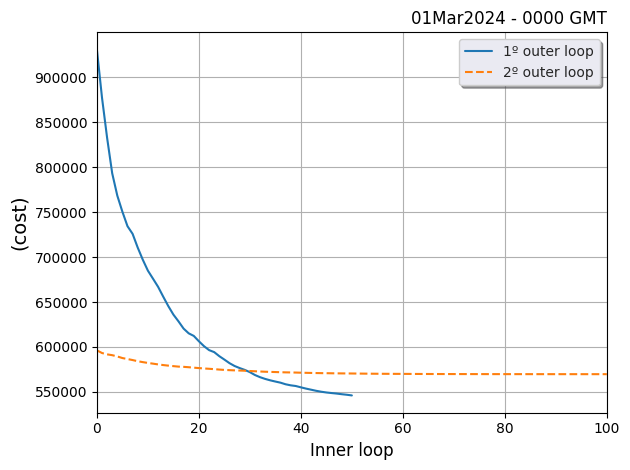

<Figure size 600x400 with 0 Axes>

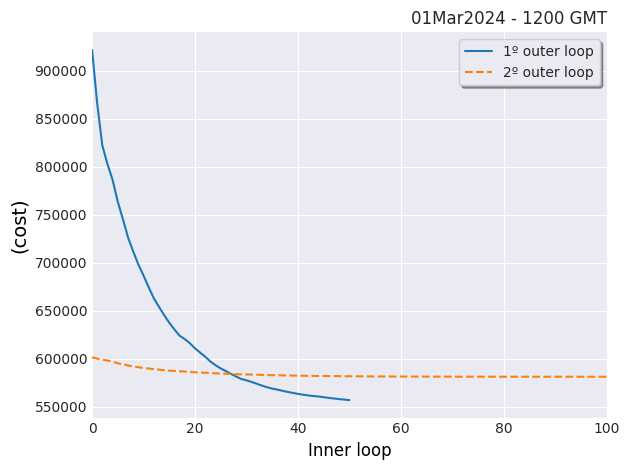

<Figure size 600x400 with 0 Axes>

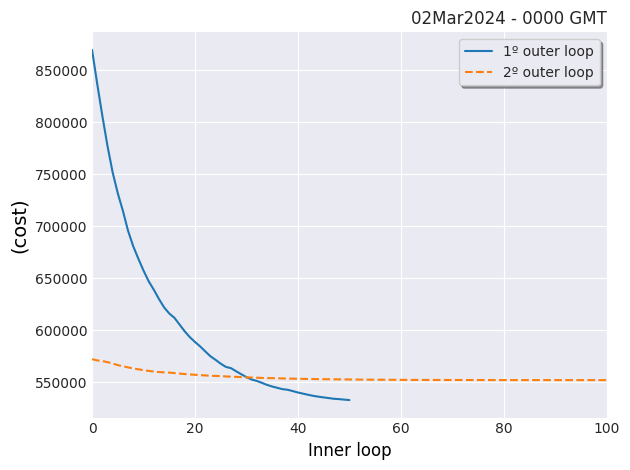

<Figure size 600x400 with 0 Axes>

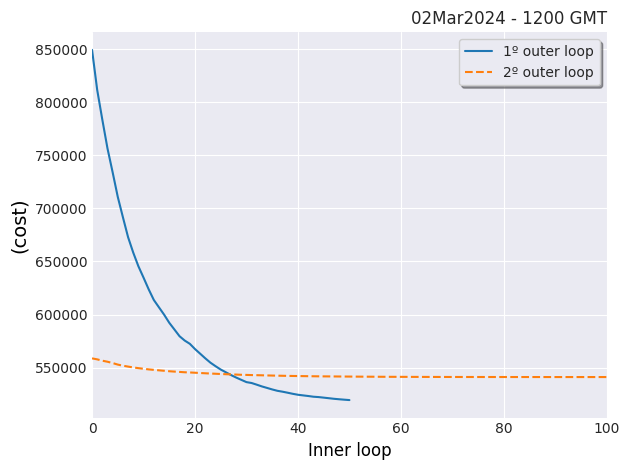

<Figure size 600x400 with 0 Axes>

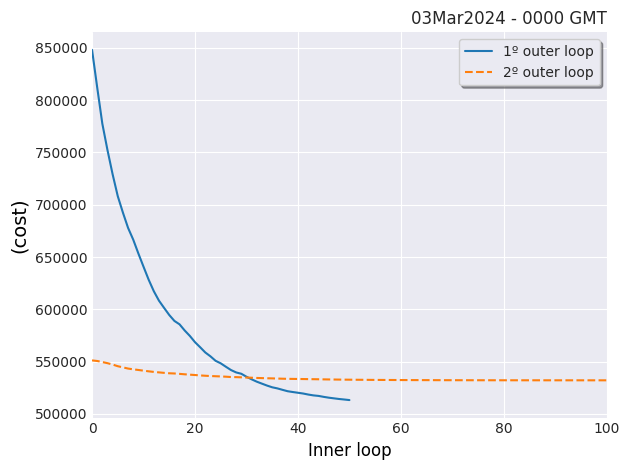

<Figure size 600x400 with 0 Axes>

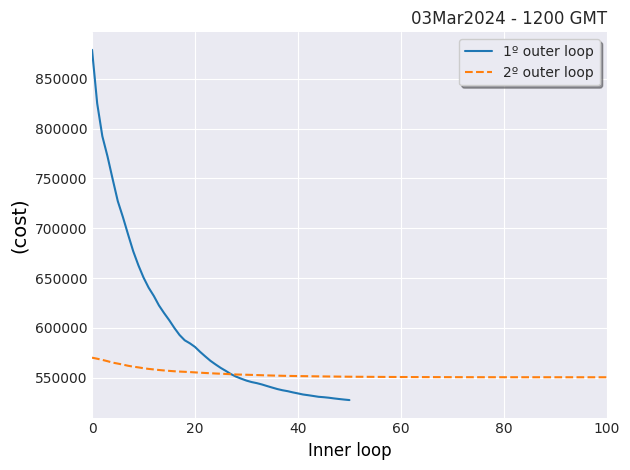

<Figure size 600x400 with 0 Axes>

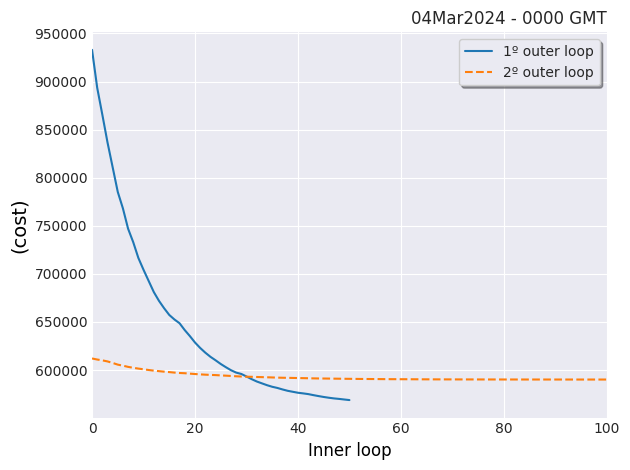

<Figure size 600x400 with 0 Axes>

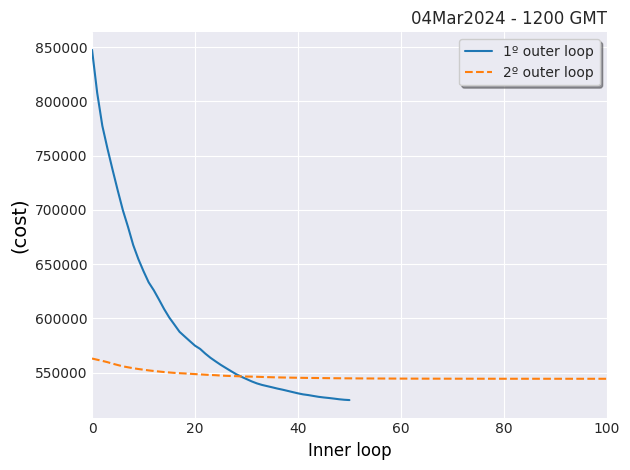

<Figure size 600x400 with 0 Axes>

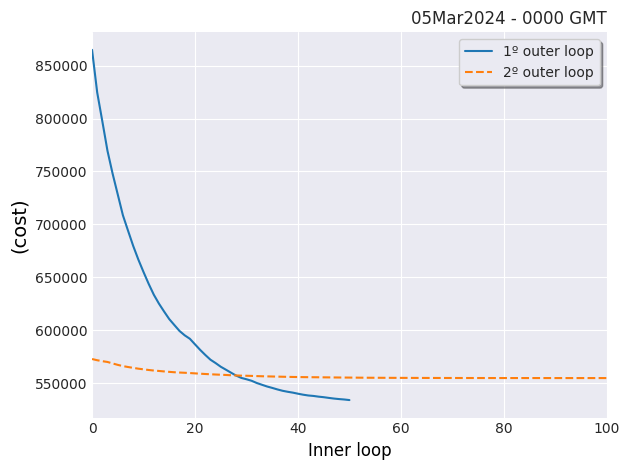

<Figure size 600x400 with 0 Axes>

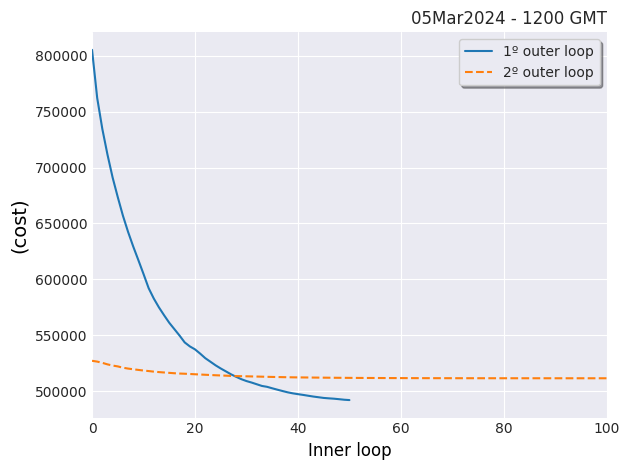

In [10]:
gd.plot_diag.fort220_plot(Self_1, dateIni=dateIni, 
                          dateFin=dateFin, 
                          nHour=nHour, 
                          Label='cost',
                          Flag=None,  
                          cost_gradient=True,  
                          Clean=None)

Agora, utiliza-se o dataframe `Self_2` para visualizar a contribuição da radiância (`Flag='26'` ou `Flag='32'`) na função custo (`J`) em relação aos *inner loops*. Neste caso é necessário atribuir `False` ao termo `cost_gradient`.

<Figure size 600x400 with 0 Axes>

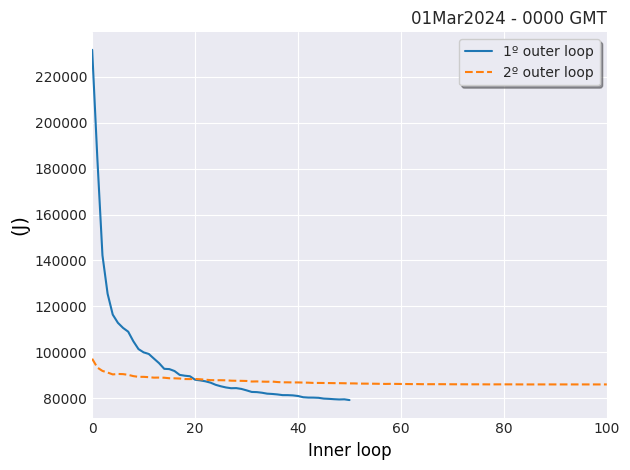

<Figure size 600x400 with 0 Axes>

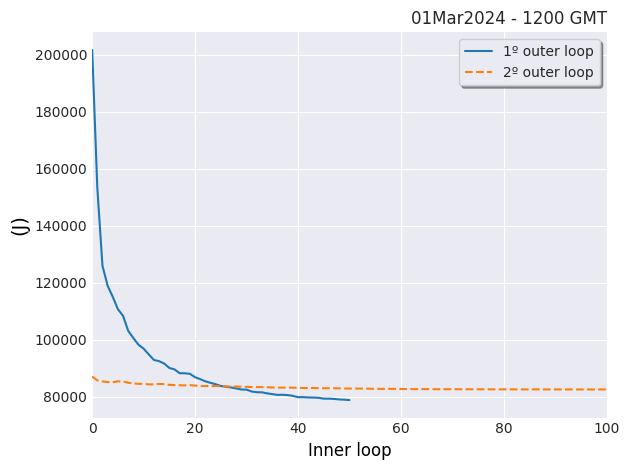

<Figure size 600x400 with 0 Axes>

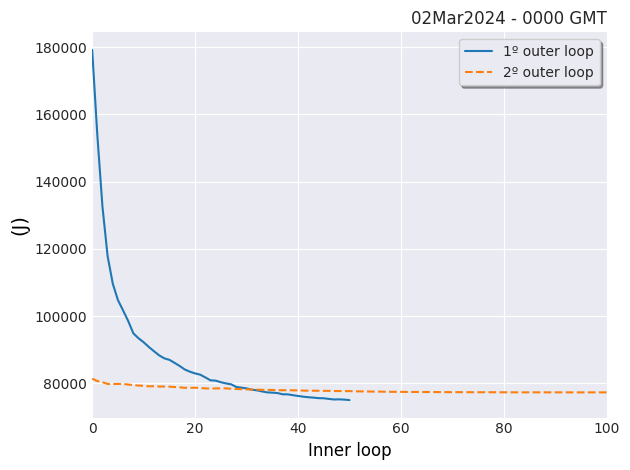

<Figure size 600x400 with 0 Axes>

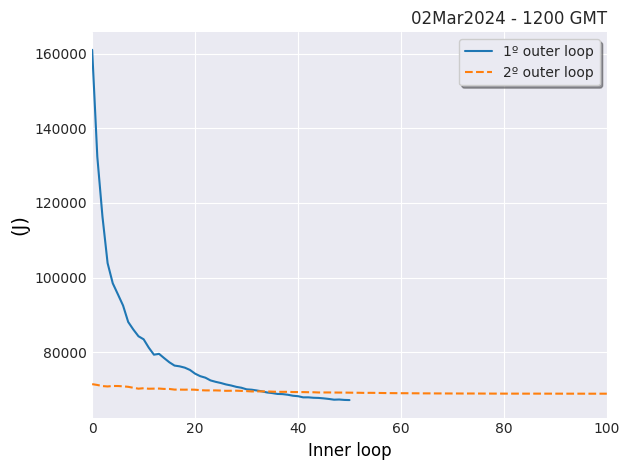

<Figure size 600x400 with 0 Axes>

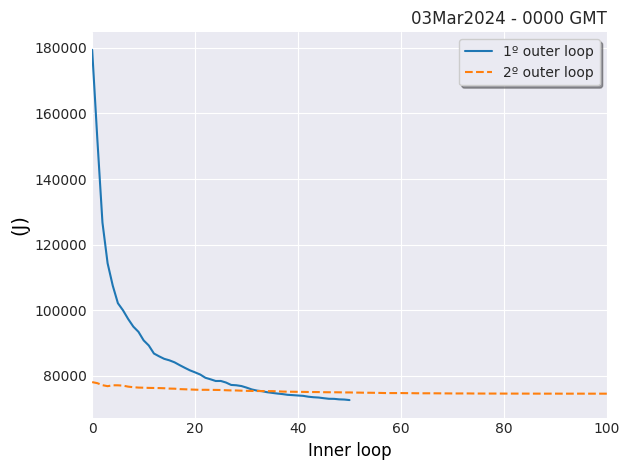

<Figure size 600x400 with 0 Axes>

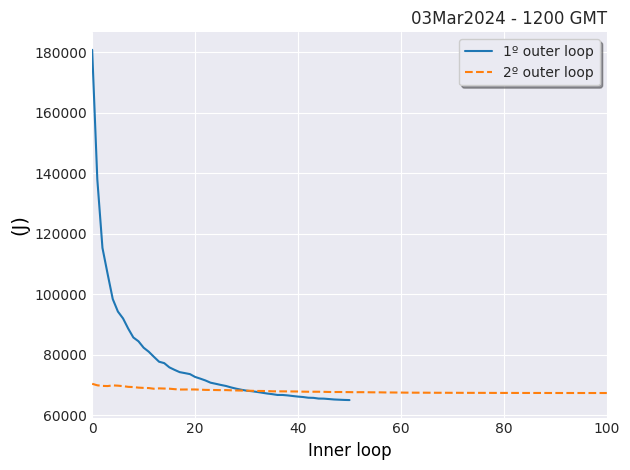

<Figure size 600x400 with 0 Axes>

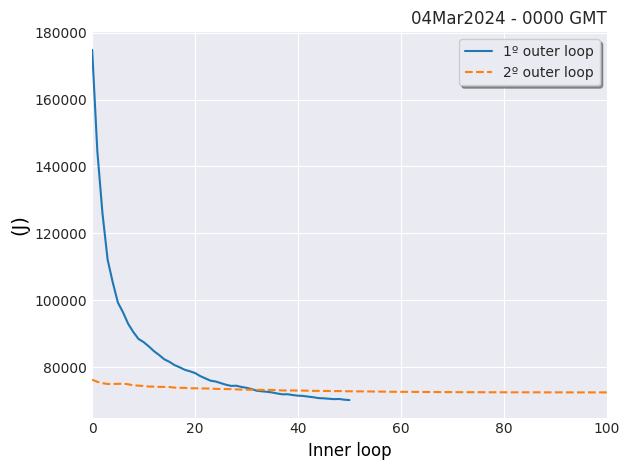

<Figure size 600x400 with 0 Axes>

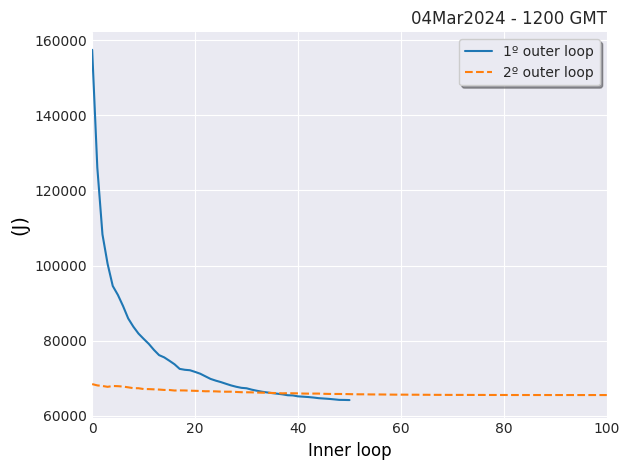

<Figure size 600x400 with 0 Axes>

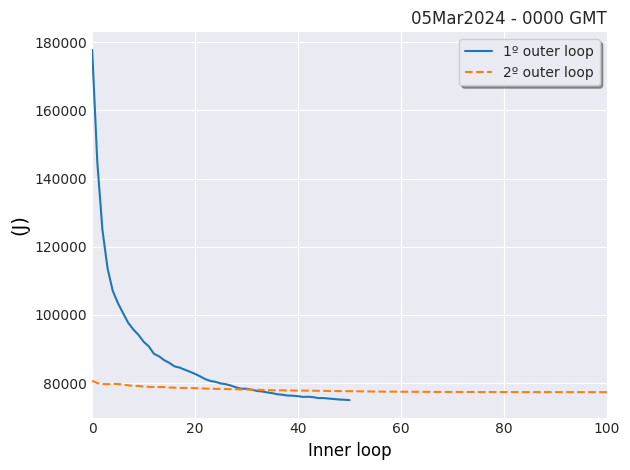

<Figure size 600x400 with 0 Axes>

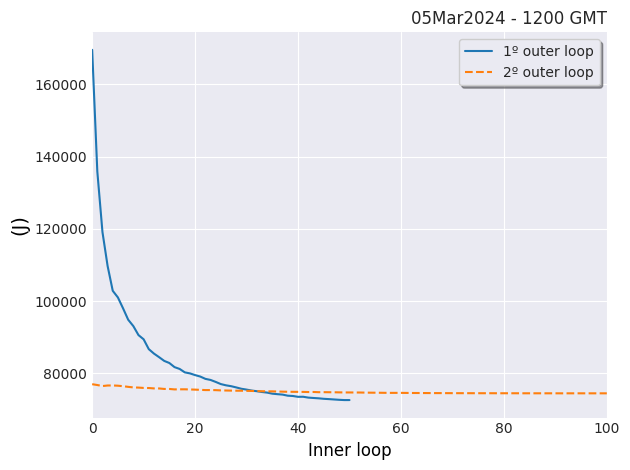

In [11]:
if EXP19:
    Flag = '26'
else:
    Flag = '32'

gd.plot_diag.fort220_plot(Self_2, dateIni=dateIni, 
                          dateFin=dateFin, 
                          nHour=nHour, 
                          Label='J',
                          Flag=Flag,  
                          cost_gradient=False,  
                          Clean=None)

2. `fort220_plot_lines(self, dateIni=None, dateFin=None, nHour="06", Label=None, Flag=None, cost_gradient=False, vmin=None, vmax=None, Clean=None, **kwargs)` retorna uma figura com o gráfico da variável `Label` em função do *inner loop*, onde cada linha contínua refere-se aos dados do primeiro *outer loop* em difrentes datas e cada linha pontilhada identifica os dados obtidos no segundo *outer loop* no range dates fornecido. Como na função `fort220_plot`, o usuário precisa setar `cost_gradient=True` quando utilizado o arquivo `Self_1` e `cost_gradient=False` quando utilizado o arquivo `Self_2`.

<Figure size 1000x600 with 0 Axes>

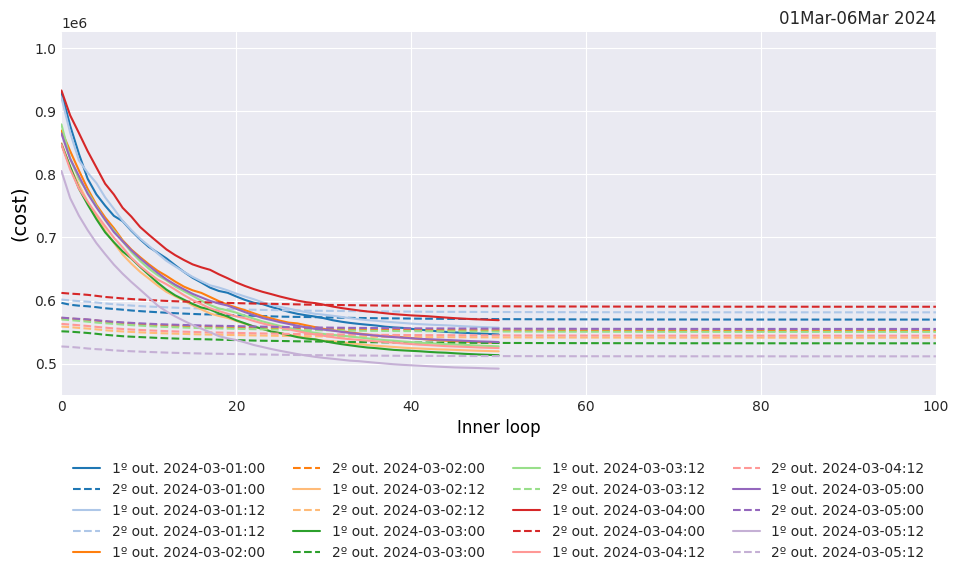

In [12]:
gd.plot_diag.fort220_plot_lines(Self_1, dateIni=dateIni, 
                                dateFin=dateFin, 
                                nHour=nHour, 
                                Label='cost', 
                                Flag=None, 
                                cost_gradient=True, 
                                vmin=None, 
                                vmax=None, 
                                Clean=None)

<Figure size 1000x600 with 0 Axes>

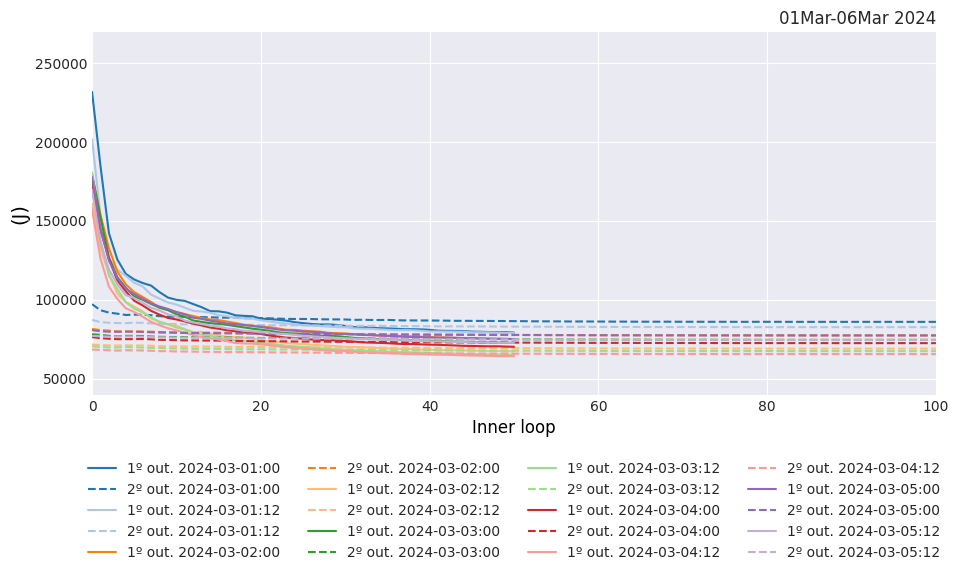

In [13]:
if EXP19:
    Flag = '26'
else:
    Flag = '32'

gd.plot_diag.fort220_plot_lines(Self_2, dateIni=dateIni, 
                                dateFin=dateFin, 
                                nHour=nHour, 
                                Label='J', 
                                Flag=Flag, 
                                cost_gradient=False, 
                                vmin=None, 
                                vmax=None, 
                                Clean=None)

3. `fort220_time(self, dateIni=None, dateFin=None, nHour="06", Label=None, Flag=None, cost_gradient=False, Clean=None)` retorna uma figura com gráfico de linhas da variável `Label` em função do tempo (`date`) no primeiro e último *inner loop* de cada *outer loop*. Como na função `fort220_plot`, o usuário precisa setar `cost_gradient=True` quando utilizado o arquivo `Self_1` e `cost_gradient=False` quando utilizado o arquivo `Self_2`.

<Figure size 1000x400 with 0 Axes>

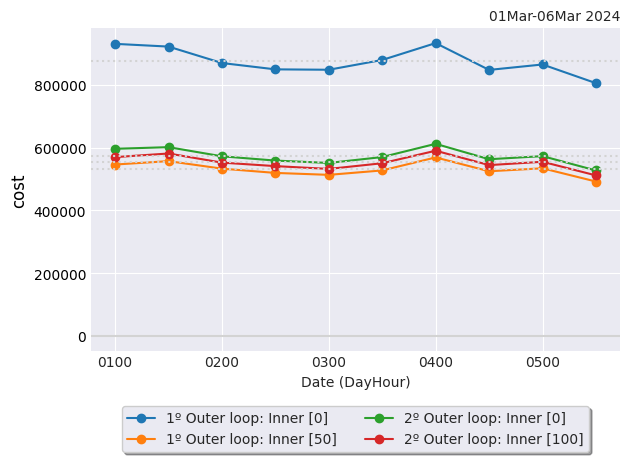

In [14]:
gd.plot_diag.fort220_time(Self_1, dateIni=dateIni, 
                          dateFin=dateFin, 
                          nHour=nHour, 
                          Label='cost',
                          Flag=None,  
                          cost_gradient=True, 
                          Clean=None)

<Figure size 1000x400 with 0 Axes>

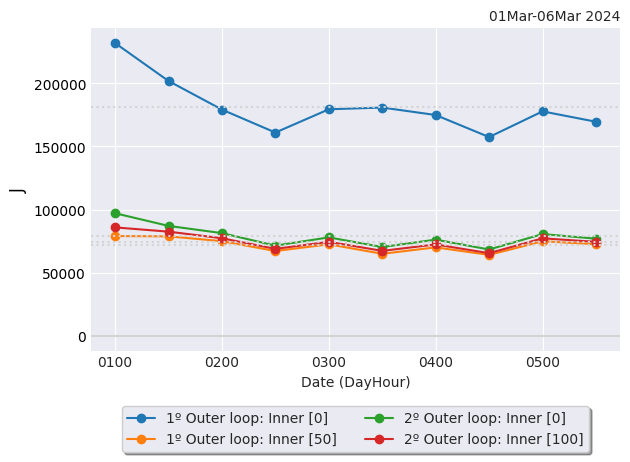

In [15]:
if EXP19:
    Flag = '26'
else:
    Flag = '32'

gd.plot_diag.fort220_time(Self_2, dateIni=dateIni, 
                          dateFin=dateFin, 
                          nHour=nHour, 
                          Label='J',
                          Flag=Flag,  
                          cost_gradient=False, 
                          Clean=None)

4. `fort220_time_Obscontrib(self1, self2, dateIni=None, dateFin=None, nHour="06", Label=None, LabelObs=None, Flag=None, Clean=None)`

A função de custo total (`cost`) é a soma da lista `J` (lista de contribuições de cada observação). Esta função plota a taxa (DQ) da contribuição da observação `LabelObs` em relação à variável `Label`. O quociente DQ é calculado para cada loop externo.

`DQ = ( J_last - J_first )/( cost_last - cost_first )`

onde,

last --> valor no último loop interno

firs --> valor no primeiro loop interno

Se `Flag=None`, são plotados gráficos de barras, onde cada barra representa uma flag, e uma figura para cada data é retornada. Se Flag for um número, dois gráficos de séries temporais são retornados:

1º) Q = (J/cost)100 no primeiro e último loop interno de cada loop externo.

2º) DQ de cada loop externo.

<Figure size 1000x400 with 0 Axes>

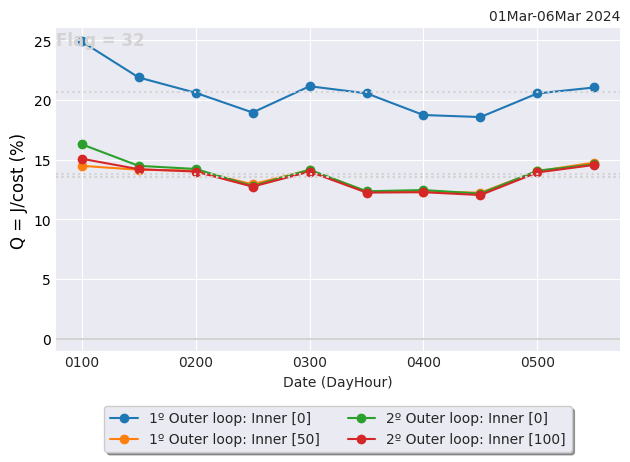

<Figure size 1000x400 with 0 Axes>

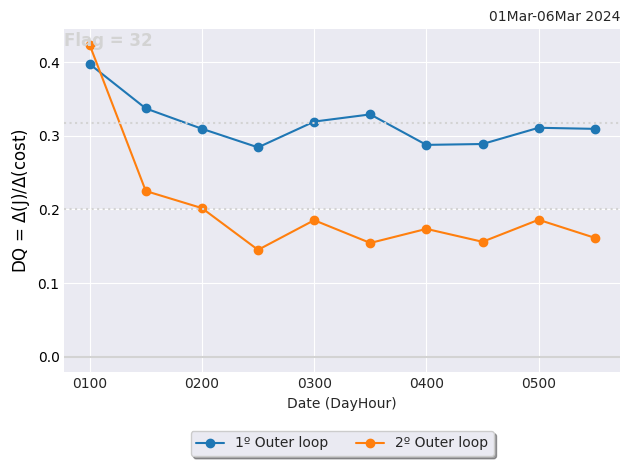

In [16]:
# Gráfico de barras de todas as Flags
# Flag = None

# Gráficos de linhas para uma Flag
if EXP19:
    Flag = '26'
else:
    Flag = '32'

gd.plot_diag.fort220_time_Obscontrib(Self_1, Self_2, 
                                     dateIni=dateIni, 
                                     dateFin=dateFin, 
                                     nHour=nHour, 
                                     Label='cost', 
                                     LabelObs='J', 
                                     Flag=Flag, 
                                     Clean=None)

x_Flags =  [1.0, 3.0, 4.0, 5.0, 18.0, 19.0, 20.0, 21.0, 25.0, 30.0, 32.0]
x_Flags =  [1.0, 3.0, 4.0, 5.0, 18.0, 19.0, 20.0, 21.0, 25.0, 30.0, 32.0]
x_Flags =  [1.0, 3.0, 4.0, 5.0, 18.0, 19.0, 20.0, 21.0, 25.0, 30.0, 32.0]
x_Flags =  [1.0, 3.0, 4.0, 5.0, 18.0, 19.0, 20.0, 21.0, 25.0, 30.0, 32.0]
x_Flags =  [1.0, 3.0, 4.0, 5.0, 18.0, 19.0, 20.0, 21.0, 25.0, 30.0, 32.0]
x_Flags =  [1.0, 3.0, 4.0, 5.0, 18.0, 19.0, 20.0, 21.0, 25.0, 30.0, 32.0]
x_Flags =  [1.0, 3.0, 4.0, 5.0, 18.0, 19.0, 20.0, 21.0, 25.0, 30.0, 32.0]
x_Flags =  [1.0, 3.0, 4.0, 5.0, 18.0, 19.0, 20.0, 21.0, 25.0, 30.0, 32.0]
x_Flags =  [1.0, 3.0, 4.0, 5.0, 18.0, 19.0, 20.0, 21.0, 25.0, 30.0, 32.0]
x_Flags =  [1.0, 3.0, 4.0, 5.0, 18.0, 19.0, 20.0, 21.0, 25.0, 30.0, 32.0]


<Figure size 800x600 with 0 Axes>

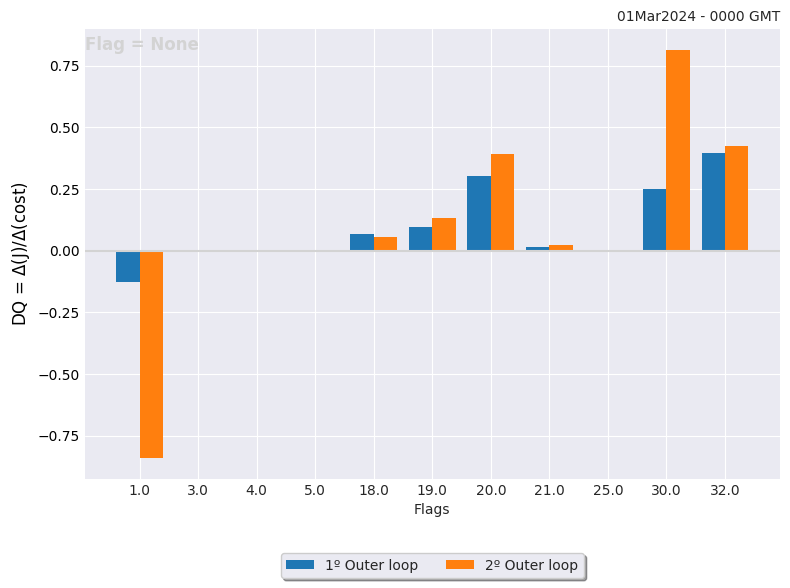

<Figure size 800x600 with 0 Axes>

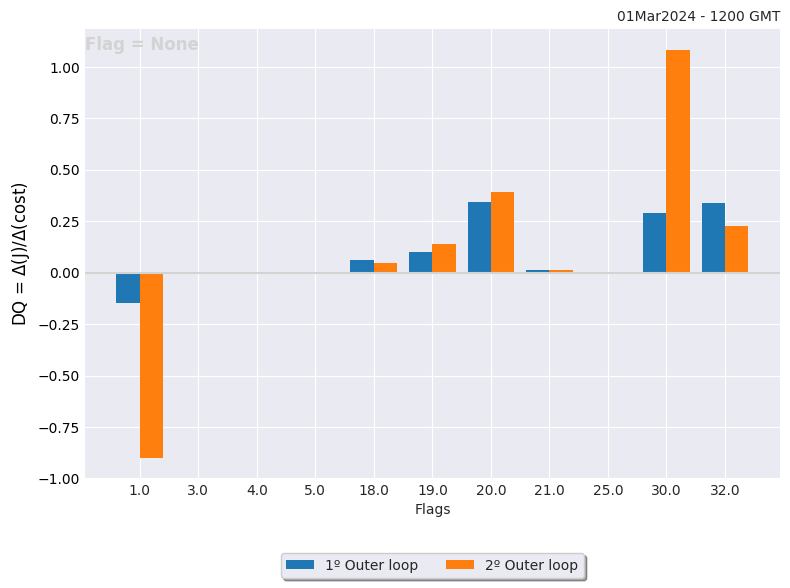

<Figure size 800x600 with 0 Axes>

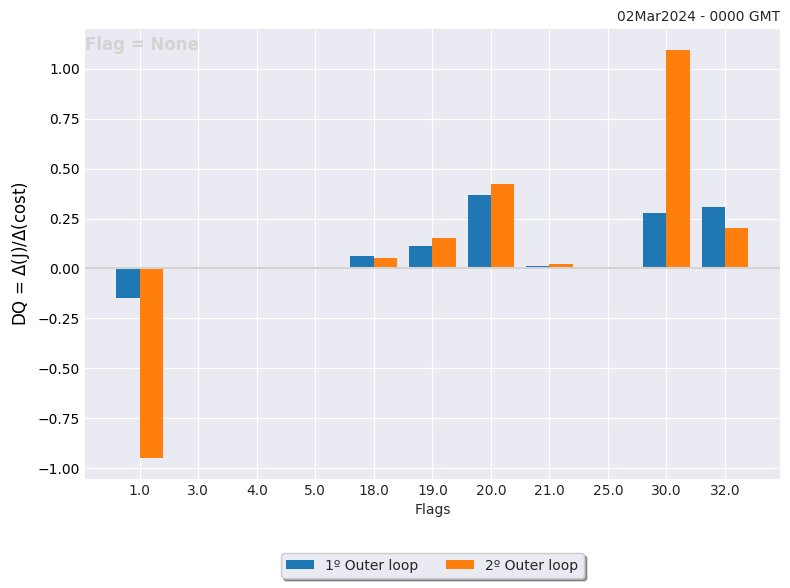

<Figure size 800x600 with 0 Axes>

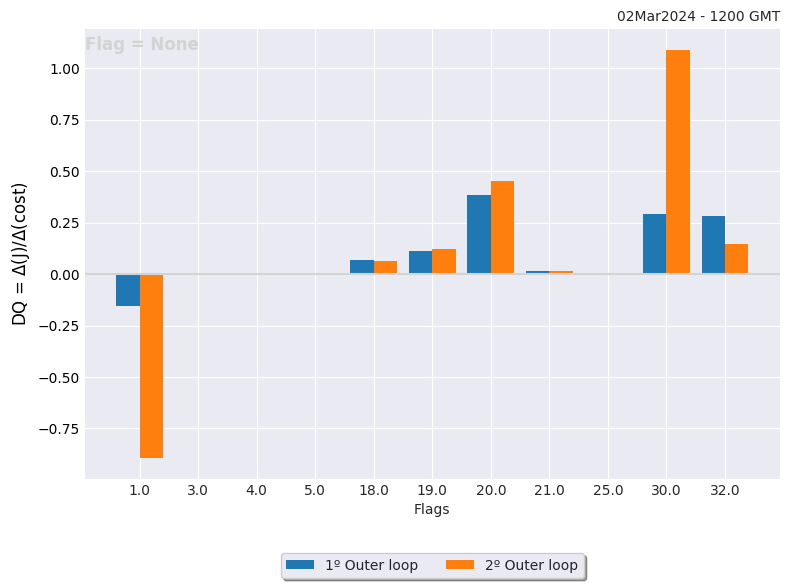

<Figure size 800x600 with 0 Axes>

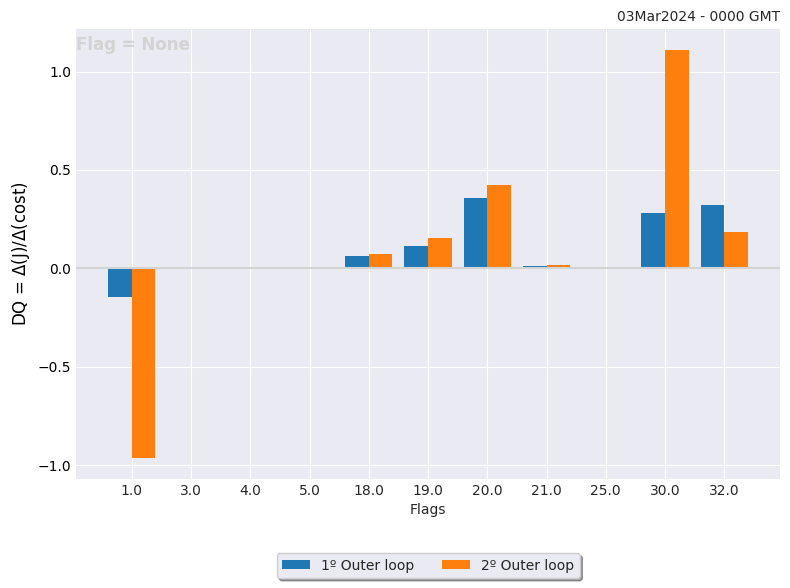

<Figure size 800x600 with 0 Axes>

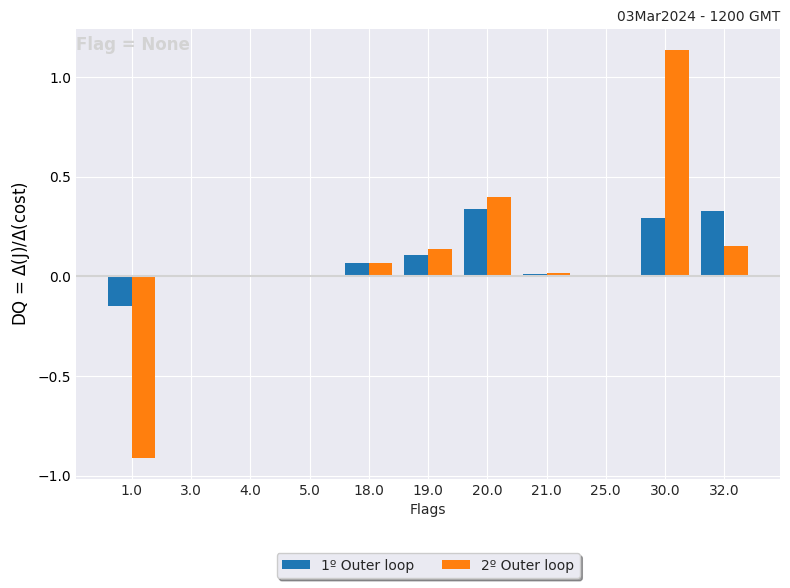

<Figure size 800x600 with 0 Axes>

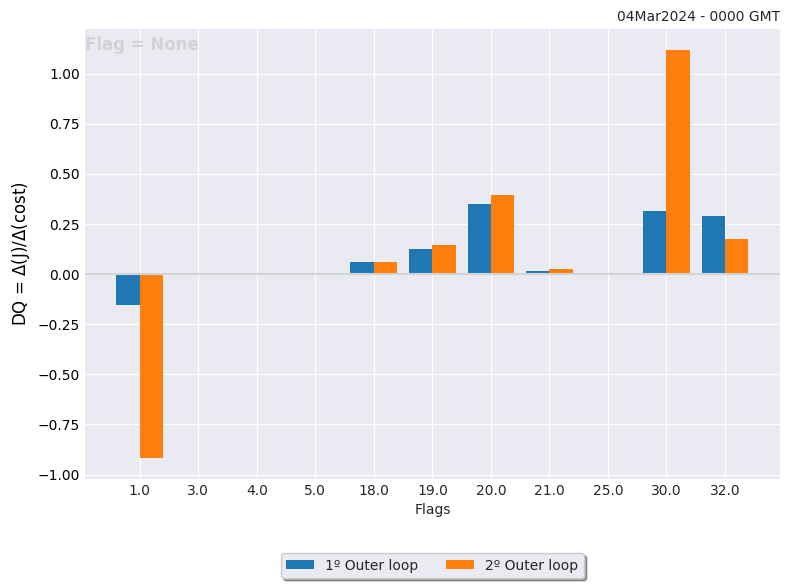

<Figure size 800x600 with 0 Axes>

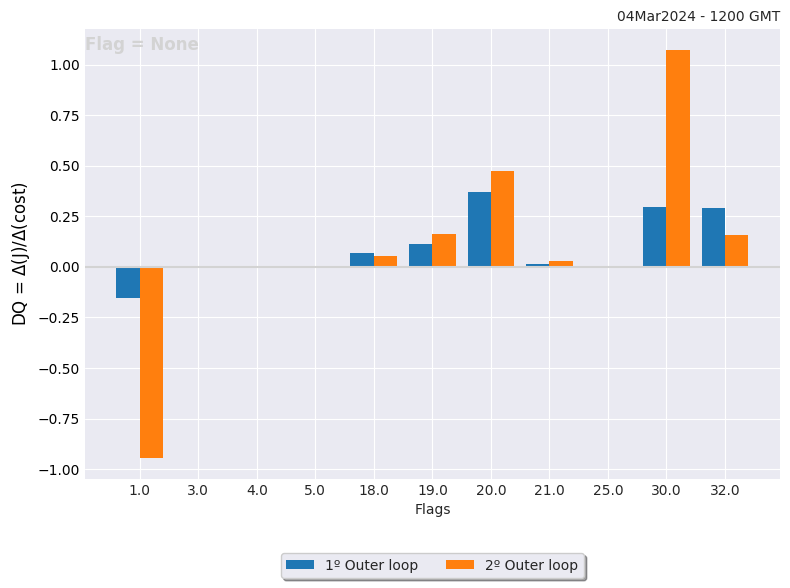

<Figure size 800x600 with 0 Axes>

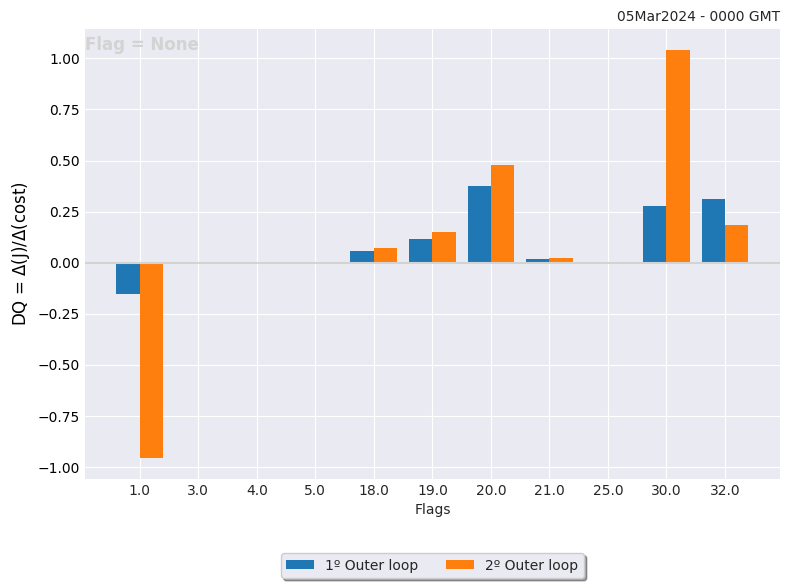

<Figure size 800x600 with 0 Axes>

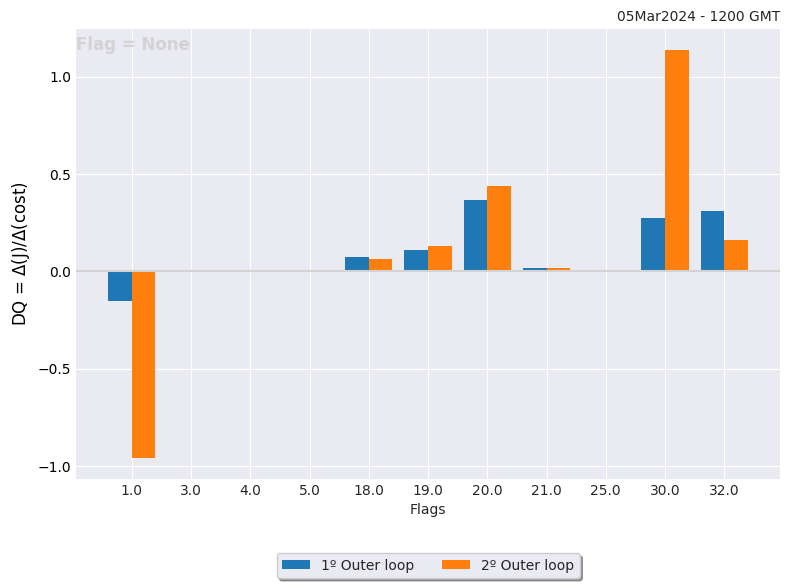

In [17]:
# Gráfico de barras de todas as Flags
Flag = None

gd.plot_diag.fort220_time_Obscontrib(Self_1, Self_2, 
                                     dateIni=dateIni, 
                                     dateFin=dateFin, 
                                     nHour=nHour, 
                                     Label='cost', 
                                     LabelObs='J', 
                                     Flag=Flag, 
                                     Clean=None)

5. `time_series_fort220(self, OuterLoop=1, Label=None, Flag=None, dateIni=None, dateFin=None, nHour="06", Clean=None)`

A função plota uma série temporal para dados do arquivo `Self_2` em diferentes flags dos termos de contribuição `J`, `b`, `c` ou de penalidade `EJ`. Um diagrama de Hovmoller é retornado se `Flag=None` ou se Flag for uma lista.

**Obs.:** considerar os nºs das flags no formato inteiro (`int`) (nesta função não utilizar o formato string para identificar a Flag). 


32 0

Outer Loop:  2  Label:  J
nloop =  100
 Preparing data for: 2024-03-01:00  - Flag:  32
nloop =  100
 Preparing data for: 2024-03-01:12  - Flag:  32
nloop =  100
 Preparing data for: 2024-03-02:00  - Flag:  32
nloop =  100
 Preparing data for: 2024-03-02:12  - Flag:  32
nloop =  100
 Preparing data for: 2024-03-03:00  - Flag:  32
nloop =  100
 Preparing data for: 2024-03-03:12  - Flag:  32
nloop =  100
 Preparing data for: 2024-03-04:00  - Flag:  32
nloop =  100
 Preparing data for: 2024-03-04:12  - Flag:  32
nloop =  100
 Preparing data for: 2024-03-05:00  - Flag:  32
nloop =  100
 Preparing data for: 2024-03-05:12  - Flag:  32


flags =  [32]
 Calculating for 2024-03-01:00
 Calculating for 2024-03-01:12
 Calculating for 2024-03-02:00
 Calculating for 2024-03-02:12
 Calculating for 2024-03-03:00
 Calculating for 2024-03-03:12
 Calculating for 2024-03-04:00
 Calculating for 2024-03-04:12
 Calculating for 2024-03-05:00
 Calculating for 2024-03-05:12


 Making Graphics...
 Done!



<Figure size 600x400 with 0 Axes>

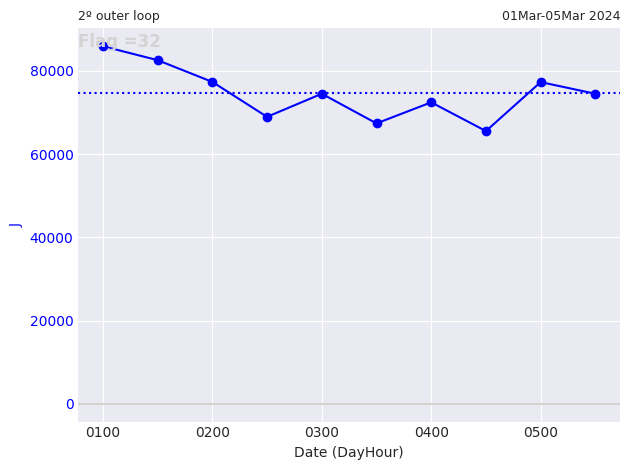

In [18]:
# indicar a flag como inteiro

#----- Flags list -----------#
# Flag = [1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, 24, 25, 26, 27]

#----- all Flags ------------#
# Flag = None

#----- number flag ----------#
if EXP19:
    Flag = 26
else:
    Flag = 32

gd.plot_diag.time_series_fort220(Self_2, OuterLoop=2, 
                                 Label='J', 
                                 Flag=Flag,  
                                 dateIni=dateIni, 
                                 dateFin=dateFin, 
                                 nHour=nHour, 
                                 Clean=False)


[1, 2, 3, 4, 5, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32] 1

Outer Loop:  2  Label:  J
nloop =  100
 Preparing data for: observation flags2024-03-01:00
 Flags:  [1, 2, 3, 4, 5, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]

nloop =  100
 Preparing data for: observation flags2024-03-01:12
 Flags:  [1, 2, 3, 4, 5, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]

nloop =  100
 Preparing data for: observation flags2024-03-02:00
 Flags:  [1, 2, 3, 4, 5, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]

nloop =  100
 Preparing data for: observation flags2024-03-02:12
 Flags:  [1, 2, 3, 4, 5, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]

nloop =  100
 Preparing data for: observation flags2024-03-03:00
 Flags:  [1, 2, 3, 4, 5, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]

nloop =  100
 Preparing data for: observation flags2024-03-03:12
 Flags:  [1, 2, 3, 4, 5, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]

nloop =  100
 Pr

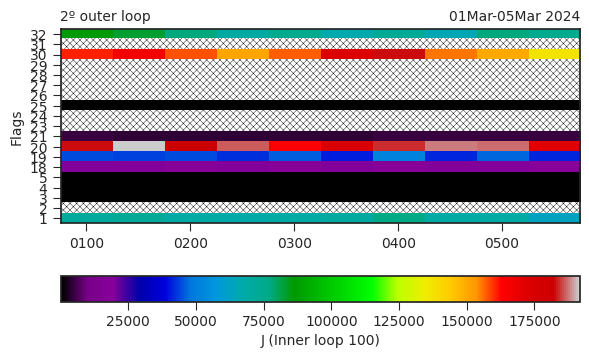

In [19]:
# indicar a flag como inteiro

#----- Flags list -----------#
# EXP19
# Flag = [1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, 24, 25, 26, 27]

#----- Flags list -----------#
# EXP21
Flag = [1, 2, 3, 4, 5, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]

#----- all Flags ------------#
# Flag = None

gd.plot_diag.time_series_fort220(Self_2, OuterLoop=2, 
                                 Label='J', 
                                 Flag=Flag,  
                                 dateIni=dateIni, 
                                 dateFin=dateFin, 
                                 nHour=nHour, 
                                 Clean=False)

6. `Mean_std_fort220(self, OuterLoop=None, cost_gradient=True, Label=None, Flag=None, dateIni=None, dateFin=None, nHour="06", Clean=None)`

Esta função plota um gráfico dos valores médios e dos desvios padrão da variável `Label` calculados no intervalo de tempo e para cada *inner loop*. No final a função retorna uma figura onde os pontos são os valores médios e o desvio padrão é representado na forma de uma barra vertical, indicando para cada *inner loop* a variabilidade do dado no intervalo de tempo.


zloops_def =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]

Outer Loop:  None , Label:  grad , Flag:  None

OuterLoop =  None : nloop1 =  50  nloop2 =  100
 Preparing data for: 2024-03-01:00
 Preparing data for: 2024-03-01:12
 Preparing data for: 2024-03-02:00
 Preparing data for: 2024-03-02:12
 Preparing data for: 2024-03-03:00
 Preparing data for: 2024-03-03:12
 Preparing data for: 2024-03-04:00
 Preparing data for: 2024-03-04:12
 Preparing data for: 2024-03-05:00
 Preparing data for: 2024-03-05:12

levs DayHour =  ['0100', '0112', '0200', '0212', '0300', '0312', '0400', '0412', '0500', '0512']
len levs DayHour =  10

Outer Loop 1 Calcula

<Figure size 1000x600 with 0 Axes>

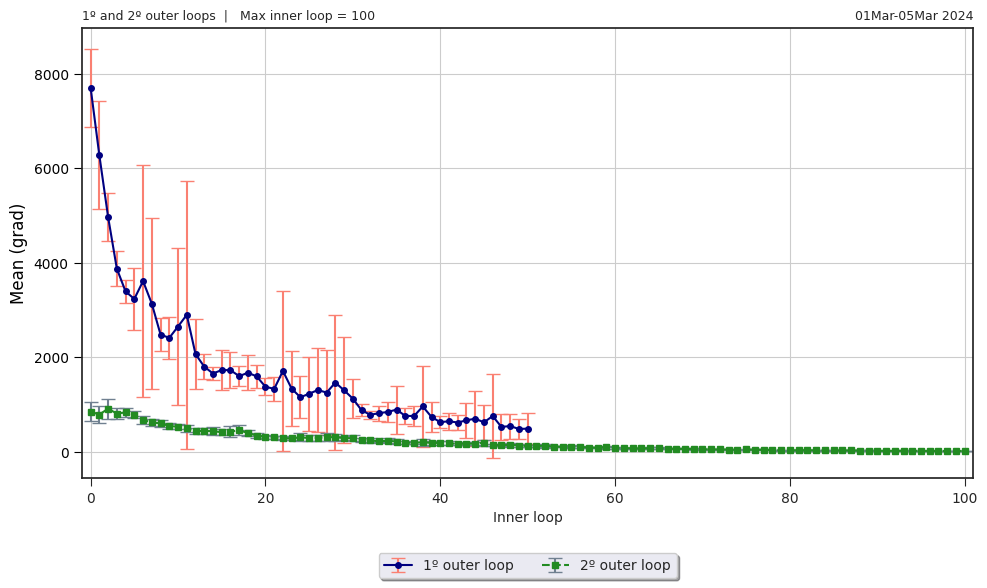

In [20]:
gd.plot_diag.Mean_std_fort220(Self_1, OuterLoop=None, 
                              cost_gradient=True, 
                              Label='grad', 
                              Flag=None, 
                              dateIni=dateIni, 
                              dateFin=dateFin, 
                              nHour=nHour, 
                              Clean=False)


zloops_def =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]

Outer Loop:  None , Label:  J , Flag:  32

OuterLoop =  None : nloop1 =  50  nloop2 =  100
 Preparing data for: 2024-03-01:00
 Preparing data for: 2024-03-01:12
 Preparing data for: 2024-03-02:00
 Preparing data for: 2024-03-02:12
 Preparing data for: 2024-03-03:00
 Preparing data for: 2024-03-03:12
 Preparing data for: 2024-03-04:00
 Preparing data for: 2024-03-04:12
 Preparing data for: 2024-03-05:00
 Preparing data for: 2024-03-05:12

levs DayHour =  ['0100', '0112', '0200', '0212', '0300', '0312', '0400', '0412', '0500', '0512']
len levs DayHour =  10

Outer Loop 1 Calculating 

<Figure size 1000x600 with 0 Axes>

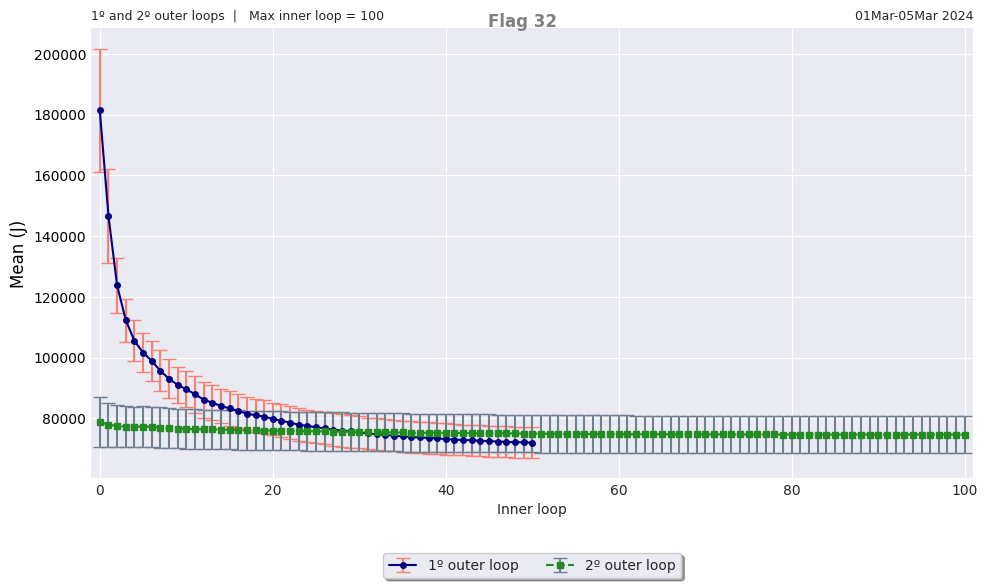

In [21]:
Label = 'J'
if EXP19:
    Flag = '26'
else:
    Flag = '32'

gd.plot_diag.Mean_std_fort220(Self_2, OuterLoop=None, 
                              cost_gradient=False, 
                              Label=Label, 
                              Flag=Flag, 
                              dateIni=dateIni, 
                              dateFin=dateFin, 
                              nHour=nHour, 
                              Clean=False)


Caso o usuário queira gerar um GiF animado com as figuras geradas pela função `fort220_plot`, basta adaptar o caminho do diretório.

In [22]:
from PIL import Image
import os

imagens = []
path = "/home/radiancia/DiagRadi-V2_issue45/notebooks/"

Label='cost'

imagens, frame_one = [], []
for i in range(len(dates)):
    tidx = i
    datefmt = dates[tidx]
    
    new = Image.open(path + '/' + 'Fort220_'+str(Label) +'_'+datefmt+'.png')
    imagens.append(new)
    
# Salvar imagem no formato gif contendo todas as imagens do 
frame_one = imagens[0]
frame_one.save("GiF-Fort220_"+str(Label) +"_"+datefmt+".gif", save_all=True, 
                append_images=imagens, duration=1000, loop=0)

print('Gif criado')
print('')

Gif criado

